2015 CAASPP test results, scatterplots

* [Source Website](http://caaspp.cde.ca.gov/sb2015/ResearchFileList)
* [Data Dictionary](http://caaspp.cde.ca.gov/sb2015/research_fixfileformat)

The county code for San Diego is 37.

The most important measurement values are: 
* pct_msa. The percentage of a subgroup that tested at or above the "Meets Standards" level. MSA = "Meet Standards or Above"
* mss. Mean Scale Score. The average test score for the subgroup. 

The geo_decomp() call seperates out the counties, schools and districts and limits the data to one grade. 

The first input cell restricts the data to the English Language Arts test. 


In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import pandas as pd
df = pd.read_csv('../ca2015_all_csv_v1.txt', na_values='*'  )

# Entities. The school, district and county names. 
ent = pd.read_csv('../ca2015entities_csv.txt')

# Here is where we specify which test. 1 is the English / Language Arts test. 
df = df[df['Test Id'] == 1]

# Create an identifier that combines the three codes. This ID is typical in other education files, 
# buyt oddly lacking from this one. 
def f(x):
    return "{:02d}{:05d}{:07d}".format(x['County Code'],x['District Code'],x['School Code'])
   
df['cds'] = df.apply(f, axis=1)
ent['cds'] = ent.apply(f, axis=1)
ent.set_index('cds',inplace = True) # index on cds so we can easily merge. 

county_names = ent['County Name']
school_names = ent['School Name']
district_names = ent[['District Name', 'County Name']]

# Friendly names of the subgroups. 
subgroups = pd.read_csv('../Subgroups.txt', header=None, names = ['subgroup_id','subgroup_name','category'],
                       index_col = 0)
subgroups['title'] = subgroups.apply(lambda row: row['category']+"; "+row['subgroup_name'], axis=1)
subgroup_names = subgroups.to_dict()['title']

# Calculate the percentage of students in the school, county or district who are members of the subgroup
df['pct_subgroup'] = df['Total Tested At Subgroup Level'] / df['Total Tested At Entity Level']

In [2]:
def geo_decomp(grade):
    """Decompose the dataframe into entries for school, district and county. Also create pivoted version of each, 
    where the subgroups are seperated into columns on the pct_msa field. """
    
    def subset(grade, df):
        """Make Pretty column names and select the grade. """
        
        dfs = df[['cds', 'County Code', 'Subgroup ID', 'pct_subgroup', 'Grade','Mean Scale Score', 
             'Percentage Standard Met and Above']]
        dfs.columns = [u'cds', 'county',  u'subgroup', u'pct_subgroup', u'grade', u'mss', u'pct_msa']

        return dfs[dfs.grade == grade]

    schools = subset(grade, df[df['School Code'] != 0])
    districts =  subset(grade, df[(df['District Code'] != 0) & (df['School Code'] == 0)])
    counties =  subset(grade, df[ (df['County Code'] != 0) & (df['District Code'] == 0) & (df['School Code'] == 0)])
    states =  subset(grade, df[ (df['County Code'] == 0)])

    counties_p = pd.pivot_table(counties,index='cds', columns='subgroup', values='pct_msa')
    districts_p = pd.pivot_table(districts[districts.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    schools_p = pd.pivot_table(schools[schools.pct_msa != 0],index='cds', columns='subgroup', values='pct_msa')
    
    return (states, counties, counties_p, districts, districts_p, schools, schools_p)
   
def munge_sg_cols(df):
    """Change the subgroup numbers in column numbers ( in the pivoted versions of the outputs from geo_decomp() )
    to human-friendly names"""
    df.columns = [ subgroup_names.get(e,e).strip().strip('"') for e in df.columns ]
    return df
    

In [3]:
# NOTE This is where we specify the grade to study, as a parameter of geo_decomp
state, counties, counties_p, districts, districts_p, schools, schools_p = geo_decomp(3)

In [4]:
#
# Support functions for scatter plots. 
#
def sg_cross(df, subgroups):
    """Select a limited subset of subgroup ids and index them on the entity ( county, district, school, via CDS)
    and the subgroup"""
    d = df[df.subgroup.isin(subgroups)].set_index(['cds','subgroup'])[['pct_subgroup','pct_msa']]
    e = d.unstack(1)
    
    # Alter the column headings to include the subgroup id. So, the 'pct_subgroup' value for subgroup 10 will be
    # renamed 'pct_subgroup_10' 
    e.columns = [ "{}_{}".format(*c) for c in e.columns.values]
    return e

def fit_plot(entity, df, x_sg, y_sg):
    """Scatter plot and regression line for how % proficient for subgroup 2 changes
    in response to subgroup 1
    
    df is the data frame to use. It should be restricted to one of the entity data frames, 
    schools, districts or counties. 
    
    x_sg is the subgroup id for the X axis. The X value will be the % of the entity that is 
    composed of the given subgroup
    
    y_sg is the subgroup id for the Y axis. The Y value will be the pct_msa for the sg_y subgroup at that entity. 
    
    """
    import matplotlib.pyplot as plt
    # fit with np.polyfit
    e = sg_cross(df, (x_sg, y_sg))
    e = e.dropna()
    
    
    x = e['pct_subgroup_{}'.format(x_sg)]
    y = e['pct_msa_{}'.format(y_sg)]
    
    
    m, b = np.polyfit(x,y, 1)

    x_sg_name = subgroup_names[x_sg]
    y_sg_name = subgroup_names[y_sg]
    
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    
    fig.suptitle('MSA of {} vs \n% in group {}'.format(y_sg_name, x_sg_name), fontsize=14, fontweight='bold', y=.98)
    ax.set_title("By {}".format(entity))

    
    ax.set_xlabel('% of entity students in group "{}"'.format(x_sg_name))
    ax.set_ylabel('% of group "{}"  at MSA'.format(y_sg_name))
    
    ax.plot(x, y, '.')
    ax.plot(x, m*x + b, '-')

    names = list(e.join(ent)['District Name'])
    
    if len(names) < 35:
        for name, xy in zip(names, zip(x,y)):                                            
            ax.annotate( name, xy=xy, xytext=(0,0), textcoords='offset points',
                       rotation = 5) 
    
def fit_plot_sd_schools(x_sg, y_sg):
    fit_plot('Schools in San Diego County', schools[schools.county == 37], x_sg, y_sg)
    
def fit_plot_sd_districts(x_sg, y_sg):
    fit_plot('Districts in San Diego County', districts[districts.county == 37], x_sg, y_sg)    

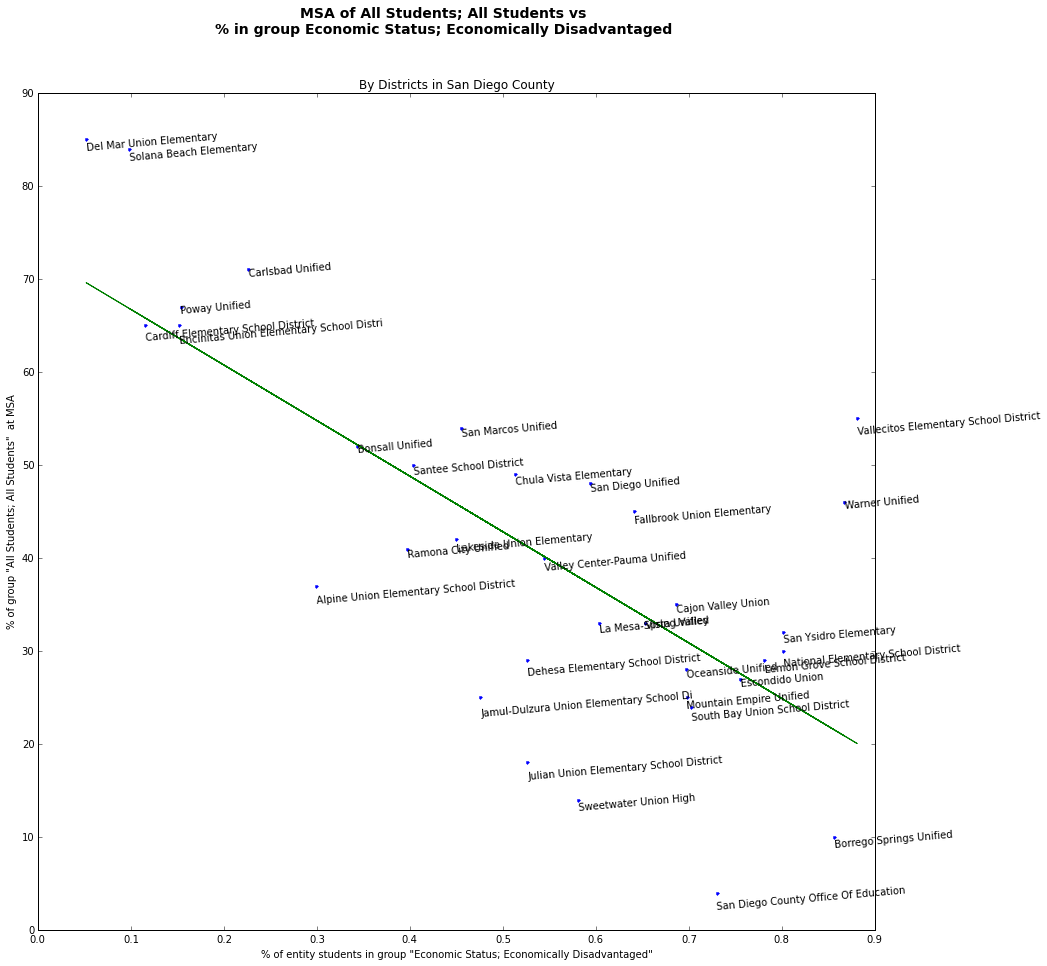

In [5]:
fit_plot_sd_districts( 31, 1) 

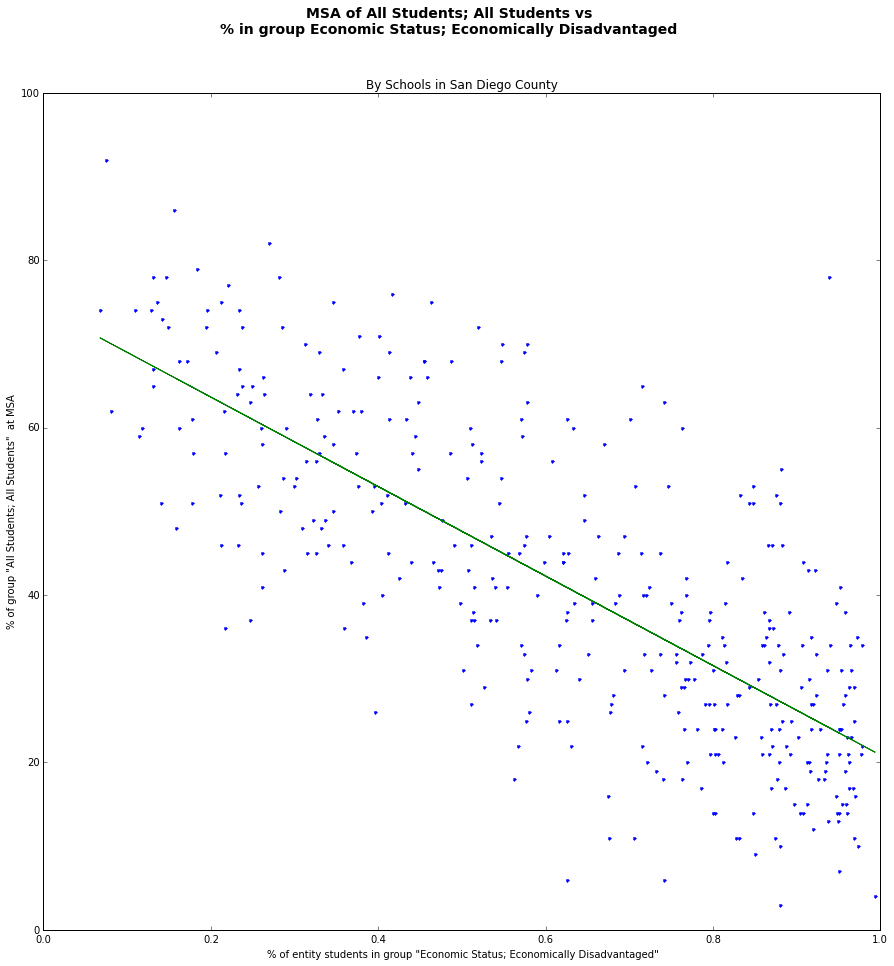

In [6]:
fit_plot_sd_schools( 31, 1) 

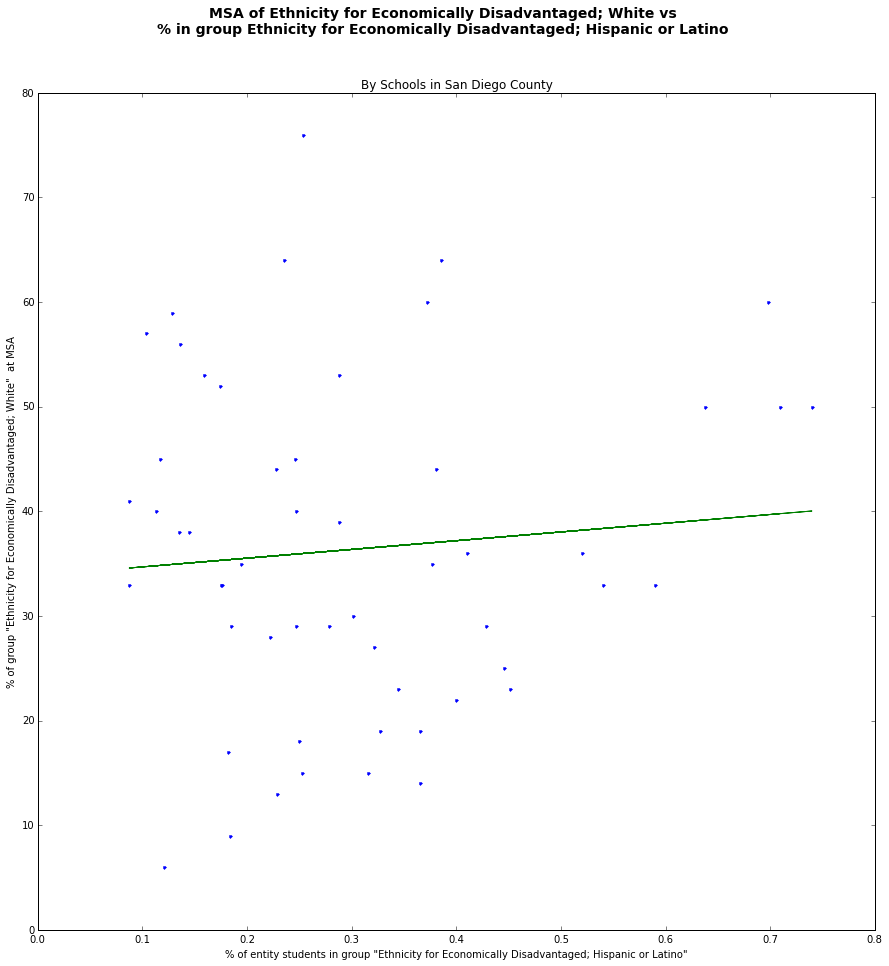

In [7]:
fit_plot_sd_schools(204, 206) # ED Whites vs % ED Hispanic

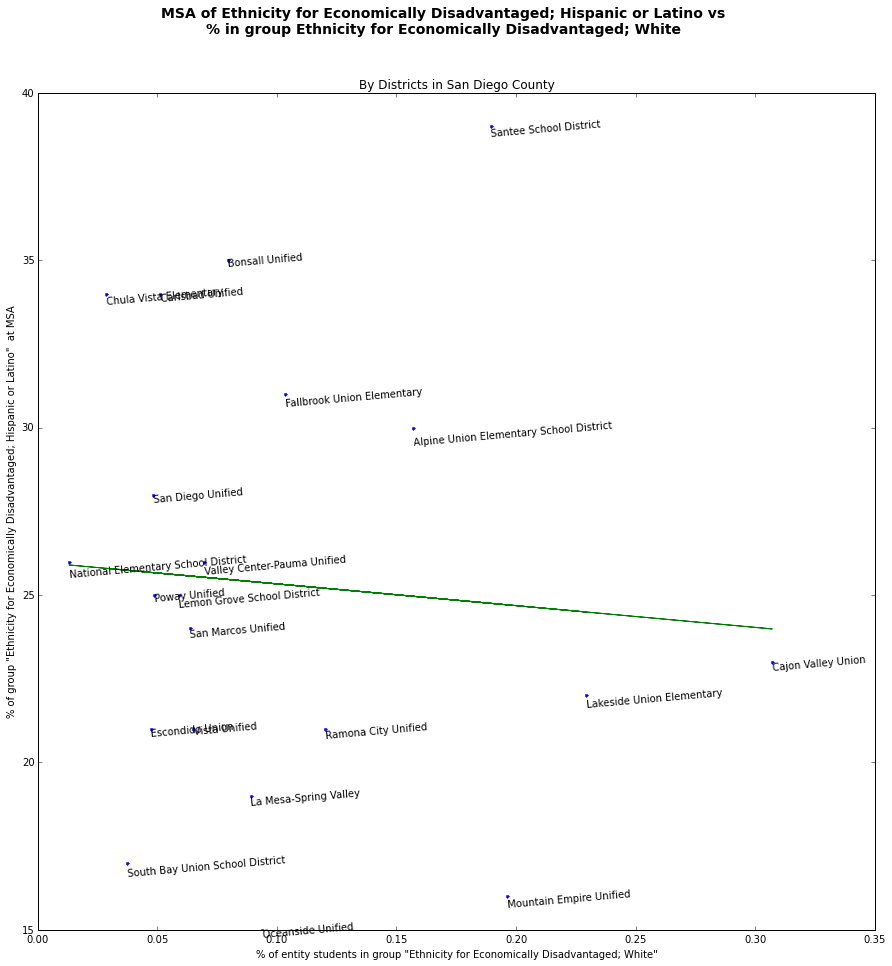

In [8]:
fit_plot_sd_districts(206, 204) # ED hispanic vs % ED whites

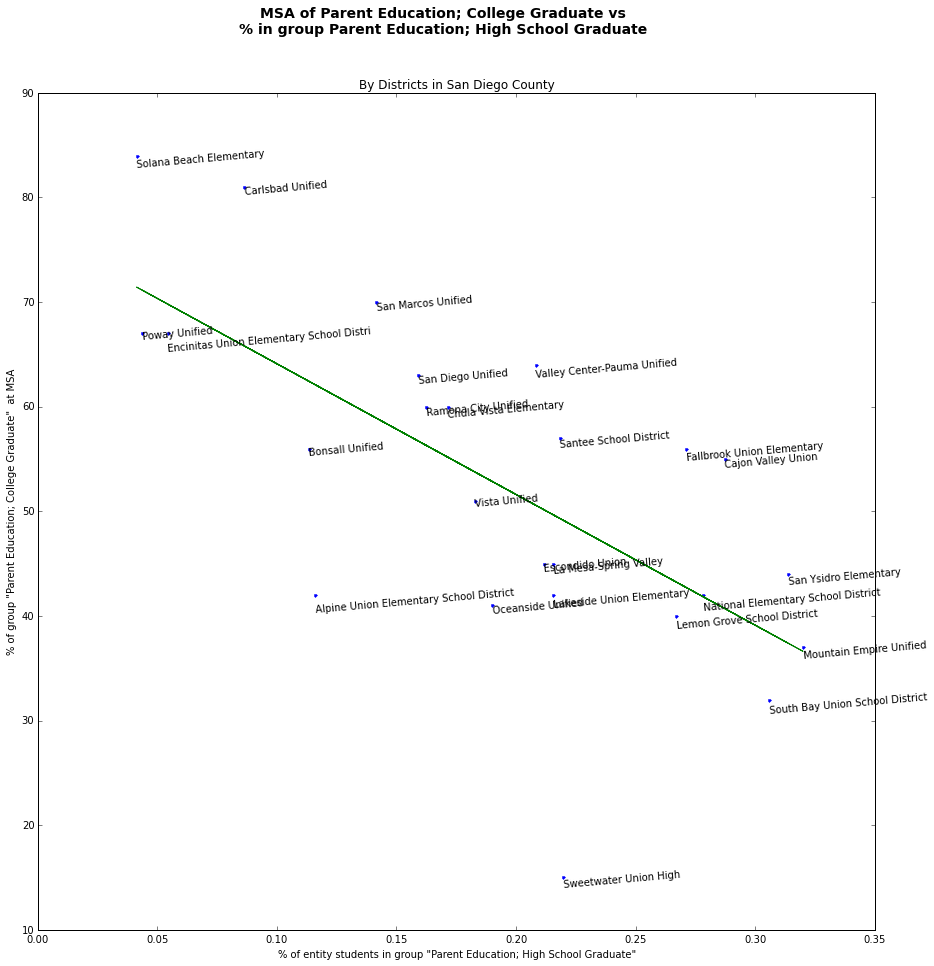

In [9]:
fit_plot_sd_districts(91, 93) # College parent vs % HS parent

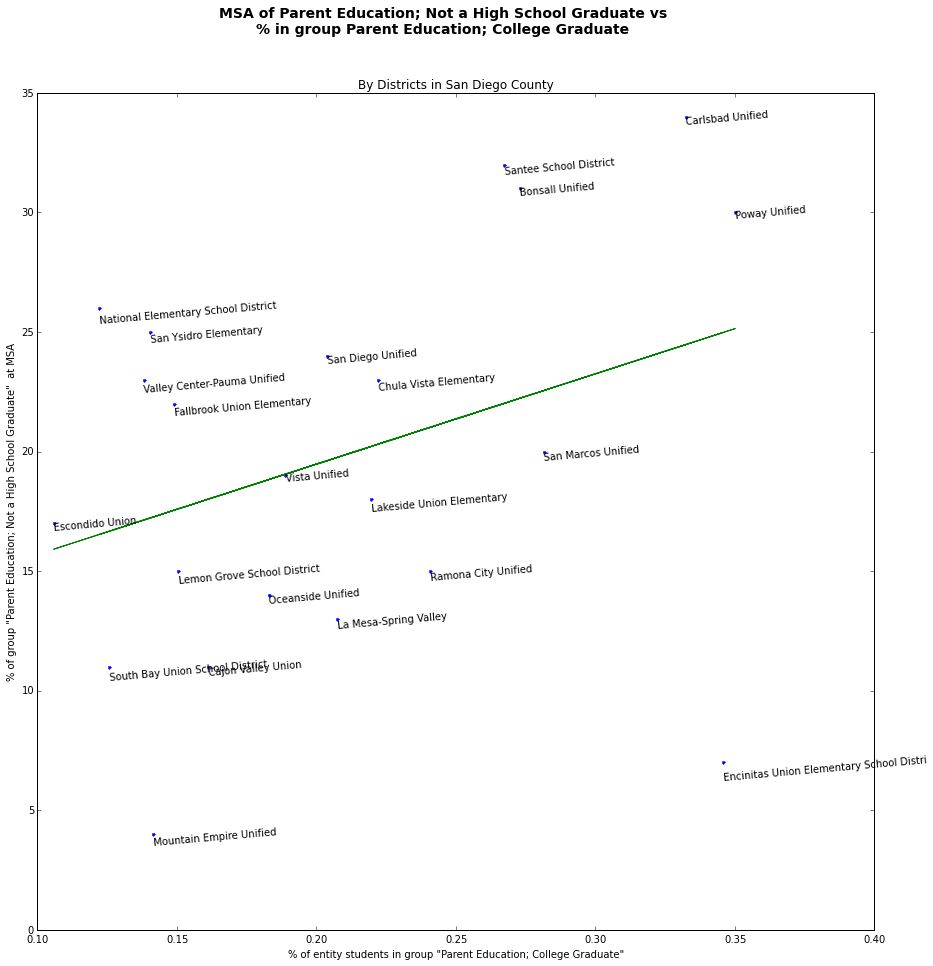

In [10]:
fit_plot_sd_districts(93, 90) 